In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 4.6 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
import pandas_datareader as pdr

start = '2020-9-30'
end = '2021-9-30'
ticker = 'PYPL'
df = pdr.data.DataReader(ticker, start=start, end=end, data_source='yahoo')

In [ ]:
df.reset_index(inplace = True)

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.133779
1,0.133080
2,0.094002
3,0.132380
4,0.092060


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((253, 7), (223, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        
        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X, 
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [06:50<00:00,  1.37s/it, acc=98.4, cost=0.000647]


simulation 2


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [06:56<00:00,  1.39s/it, acc=98.6, cost=0.000482]


simulation 3


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [06:54<00:00,  1.38s/it, acc=97.7, cost=0.00121]


simulation 4


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [06:49<00:00,  1.36s/it, acc=97.9, cost=0.00127]


simulation 5


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [06:42<00:00,  1.34s/it, acc=97.6, cost=0.00156]


simulation 6


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [06:06<00:00,  1.22s/it, acc=97.6, cost=0.0016]


simulation 7


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [06:02<00:00,  1.21s/it, acc=97.7, cost=0.00131]


simulation 8


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [06:03<00:00,  1.21s/it, acc=98.2, cost=0.000817]


simulation 9


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [06:03<00:00,  1.21s/it, acc=98.5, cost=0.000564]


simulation 10


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [06:04<00:00,  1.21s/it, acc=98.1, cost=0.00098]


#**Sanity check**
Some of our models might not have stable gradient, so forecasted trend might really hangwired. You can use many methods to filter out unstable models.

This method is very simple,

If one of element in forecasted trend lower than min(original trend).
If one of element in forecasted trend bigger than max(original trend) * 2.
If both are true, reject that trend.


In [ ]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-5:]

['2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29', '2021-10-30']

In [ ]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

10

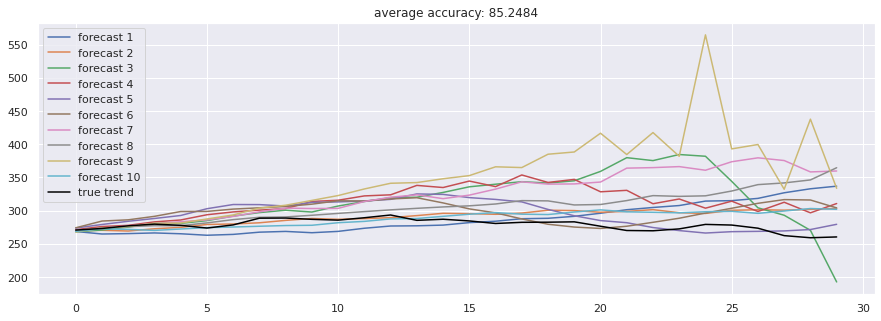

<Figure size 432x288 with 0 Axes>

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()
plt.savefig(f'{ticker.upper()}.png')

In [ ]:
# # accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]
# accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# plt.figure(figsize = (15, 5))
# for no, r in enumerate(accepted_results):
#     plt.plot(r, label = 'forecast %d'%(no + 1))
# plt.plot(df['Close'], label = 'true trend', c = 'black')
# plt.legend()
# plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

# x_range_future = np.arange(len(results[0]))
# plt.xticks(x_range_future[::30], date_ori[::30])

# plt.show()
# plt.savefig('GOOG.png')

In [ ]:

results_df = pd.DataFrame(results).T
results_df['Dates'] = date_ori[-test_size:]
results_df = results_df.set_index('Dates')
results_df.to_csv(f'{ticker.upper()}_pred.csv')

In [ ]:
results_df

,0,1,2,3,4,5,6,7,8,9
Dates,,,,,,,,,,
2021-10-01,268.455000,269.423788,268.031987,271.202919,273.648285,273.975951,270.260060,269.706420,267.630944,268.639511
2021-10-02,264.635980,270.236131,270.666074,275.919207,278.969981,284.152847,273.015854,273.723814,273.317419,272.517025
2021-10-03,265.247813,269.137175,275.043561,277.701015,283.815401,286.008570,276.921239,275.684522,276.116438,271.635578
2021-10-04,266.241027,272.525115,280.581517,282.904320,288.023090,291.245135,280.244147,277.197050,280.843294,270.052819
2021-10-05,265.002414,274.653091,280.606617,285.775817,292.536495,298.511670,283.116073,277.162350,281.154848,272.171892
2021-10-06,262.758730,278.982881,284.776385,293.636695,302.727474,298.642493,285.860745,281.378235,287.289415,274.231863
2021-10-07,264.052479,279.740535,291.600636,297.900410,309.046247,302.167577,291.158128,286.302737,293.323597,275.165642
2021-10-08,267.398788,281.539907,296.893681,300.606965,308.899766,304.084927,298.070468,289.801932,303.610834,276.308764
2021-10-09,268.533643,285.151282,300.462171,303.002345,306.756045,306.104532,303.668691,290.321739,307.965690,277.384510


In [ ]:
from time import sleep
sleep(1800)